In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Higgs.tools.ImplementationUtils import (
    readHEPDataCsv,
    implementPairDecayLimit,
    implementPairProductionLimit,
)
from Higgs import bounds as HB
from Higgs import predictions as HP
from Higgs import Predictions
from itertools import product

import os, sys

sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
import MassResolutions as resolution


# ATLAS 13TeV LHC

## `H > hSM hSM > bb/tautau/WW/gamgam` combination [1906.02025](https://arxiv.org/abs/1906.02025)

The quoted limit does not include the BRs of daughter higgses, but assumes hSM. We multiply with the combined reference BR into all considered channels and then include the BRs in the process definition.

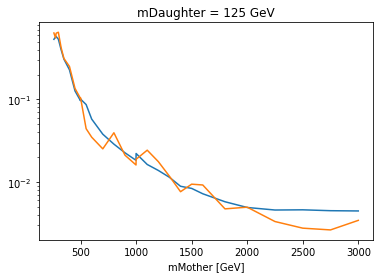

Looks good. Saving this to H_LHC13_ATLAS_36.json


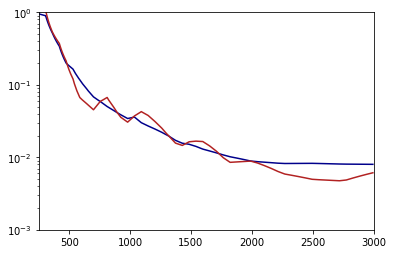

In [14]:
dfsLow = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1738524/Spin-0%20cross-section%20upper%20limits%20of%20combination%20in%20low%20mass/1/csv"
)
dfsMid = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1738524/Spin-0%20cross-section%20upper%20limits%20of%20combination%20in%20mid%20mass/1/csv"
)
dfsHigh = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1738524/Spin-0%20cross-section%20upper%20limits%20of%20combination%20in%20high%20mass/1/csv"
)

dfLow = dfsLow[1].rename(
    columns={
        "$m_{X}$ [GeV]": "mMother",
        "Upper limit on \\sigma_{ggF}(pp\\to X \\to HH) at 95% CL of the combination in the low-mass range [pb]": "obs",
    }
)
assert np.allclose(dfLow.mMother, dfsLow[1].iloc[:, 0])
dfLow["exp"] = dfsLow[2][
    "Upper limit on \\sigma_{ggF}(pp\\to X \\to HH) at 95% CL of the combination in the low-mass range [pb]"
]
dfMid = dfsMid[1].rename(
    columns={
        "$m_{X}$ [GeV]": "mMother",
        "Upper limit on \\sigma_{ggF}(pp\\to X \\to HH) at 95% CL of the combination in the intermediate-mass range [pb]": "obs",
    }
)
assert np.allclose(dfMid.mMother, dfsMid[1].iloc[:, 0])
dfMid["exp"] = dfsMid[2][
    "Upper limit on \\sigma_{ggF}(pp\\to X \\to HH) at 95% CL of the combination in the intermediate-mass range [pb]"
]
dfHigh = dfsHigh[1].rename(
    columns={
        "$m_{X}$ [GeV]": "mMother",
        "Upper limit on \\sigma_{ggF}(pp\\to X \\to HH) at 95% CL of the combination in the high-mass range [pb]": "obs",
    }
)
assert np.allclose(dfHigh.mMother, dfsHigh[1].iloc[:, 0])
dfHigh["exp"] = dfsHigh[2][
    "Upper limit on \\sigma_{ggF}(pp\\to X \\to HH) at 95% CL of the combination in the high-mass range [pb]"
]
assert np.max(dfLow.mMother) == np.min(dfMid.mMother)
assert np.max(dfMid.mMother) == np.min(dfHigh.mMother)

dfLow.loc[len(dfLow) - 1, "mMother"] -= 1
dfMid.loc[len(dfMid) - 1, "mMother"] -= 1

df = pd.concat([dfLow, dfMid, dfHigh])
df["mDaughter1"] = 125
decModes = ["bb", "tautau", "WW", "gamgam"]
ref = HP.SMHiggs(125)
refBr = np.sum([ref.br(d) for d in decModes]) ** 2

df.exp *= refBr
df.obs *= refBr
limitFile = implementPairDecayLimit(
    "1906.02025",
    {
        "production": ["H"],
        "firstDecay": decModes,
        "secondDecay": decModes,
    },
    "Fig. 5a",
    df,
    massResolution={
        "firstDaughter": {"absolute": 10, "relative": 0},
        "secondDaughter": {"absolute": 10, "relative": 0},
        "mother": {"absolute": 10, "relative": 0.1},
    },
    constraints={
        "firstDaughter": [
            {
                "modelLike": "SMHiggs",
                "process": {"channels": [["none", d] for d in decModes]},
            }
        ],
        "secondDaughter": [
            {
                "modelLike": "SMHiggs",
                "process": {"channels": [["none", d] for d in decModes]},
            }
        ],
    },
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
hh.setDecayWidth("h1", "h1", 1.0)
h1.setMass(125)
HP.effectiveCouplingInput(h1, HP.smLikeEffCouplings)
hm = np.linspace(250, 3000)
r = np.linspace(1e-3, 1)


def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC13", "ggH", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r, expR * refBr, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR * refBr, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")


## non-res `pp > hSM hSM` combination [1906.02025](https://arxiv.org/abs/1906.02025)

In [17]:
df = pd.DataFrame({"m": [125], "obs": 6.9, "exp": 10})
refCxn = 33.5e-3
decs = ["bb", "tautau", "gamgam", "WW"]
sm = HP.SMHiggs(125)
df.obs *= refCxn * sum((sm.br(d) for d in decs)) ** 2
df.exp *= refCxn * sum((sm.br(d) for d in decs)) ** 2

limitFile = implementPairProductionLimit(
    1738524,
    {"firstDecay": decs, "secondDecay": decs},
    "Fig. 2",
    df,
    massResolution={  # guess +-5 because gamgam is in there,
        "firstParticle": {"absolute": 10, "relative": 0.0},
        "secondParticle": {"absolute": 10, "relative": 0.0},
    },
    idSuffix=1,
    constraints={
        "firstParticle": [
            {
                "modelLike": "SMHiggs",
                "process": {"channels": [["none", d] for d in decModes]},
            }
        ],
        "secondParticle": [
            {
                "modelLike": "SMHiggs",
                "process": {"channels": [["none", d] for d in decModes]},
            }
        ],
    },
)

lim = HB.Limit(limitFile)

pred = Predictions()
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h1.setMass(125)
HP.effectiveCouplingInput(h1, HP.smLikeEffCouplings)
pred.setBsmPairCxn(
    "LHC13",
    "h1",
    "h1",
    1 / sum((sm.br(d) for d in decs)) ** 2,
)
res = lim.apply(pred)
print(res)
assert np.isclose(res[0].obsRatio(), 1.0 / df.obs[0])
assert np.isclose(res[0].expRatio(), 1.0 / df.exp[0])


Looks good. Saving this to nonres_LHC13_ATLAS_36.json
[<Higgs.bounds.AppliedLimit limitId: 1906020251, obsRatio: 5.783, expRatio: 3.990, for: ["h1", "+", "h1"]>]


## non-res `pp > hSM hSM > bb + WW/ZZ/tautau` [1908.06765](https://arxiv.org/abs/1908.06765)

In [20]:
df = pd.DataFrame({"m": [125], "obs": 1.2, "exp": 0.9})

decs = ["WW", "ZZ", "tautau"]
sm = HP.SMHiggs(125)
df.obs *= sum((sm.br(d) for d in decs)) * sm.br("bb")
df.exp *= sum((sm.br(d) for d in decs)) * sm.br("bb")

limitFile = implementPairProductionLimit(
    "1908.06765",
    {"firstDecay": ["bb"], "secondDecay": decs},
    "Tab. 5",
    df,
    massResolution={
        "firstParticle": {"absolute": 30, "relative": 0.0},  # bb resolution is bad
        "secondParticle": {
            "absolute": 10,
            "relative": 0.0,
        },  # guess +-5 because ZZ>4l is in there
    },
    constraints={
        "secondParticle": [
            {
                "modelLike": "SMHiggs",
                "process": {"channels": [["none", d] for d in decModes]},
            }
        ],
    },
)

lim = HB.Limit(limitFile)

pred = Predictions()
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h1.setDecayWidth("bb", 1.0)
h1.setMass(125)
h2 = pred.addParticle(HP.NeutralScalar("h2"))
h2.setMass(125)
HP.effectiveCouplingInput(h2, HP.smLikeEffCouplings)
pred.setBsmPairCxn("LHC13", "h1", "h2", 1 / sum((sm.br(d) for d in decs)))
res = lim.apply(pred)
print(res)
assert np.isclose(res[0].obsRatio(), 1.0 / df.obs[0])
assert np.isclose(res[0].expRatio(), 1.0 / df.exp[0])


Looks good. Saving this to nonres_LHC13_ATLAS_139.json
[<Higgs.bounds.AppliedLimit limitId: 190806765, obsRatio: 4.732, expRatio: 6.310, for: ["h1", "+", "h2"]>]


# ATLAS 8TeV LHC

## `H > hSM hSM > bb/tautau/WW/gamgam` [1509.04670](https://arxiv.org/abs/1509.04670)
The quoted limit does not include the BRs of daughter higgses, but assumes hSM. We multiply with the combined reference BR into all considered channels and then include the BRs in the process definition.

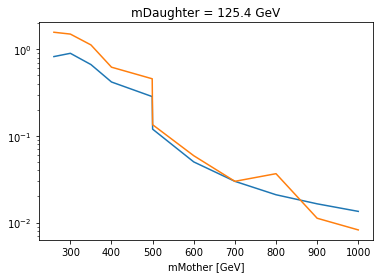

Looks good. Saving this to H_LHC8_ATLAS_20.json


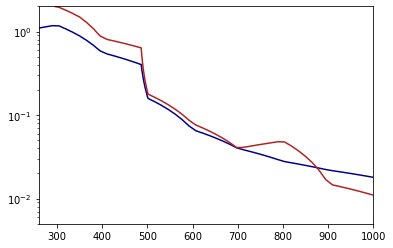

In [4]:
df = pd.DataFrame(
    data={
        "mMother": [260, 300, 350, 400, 499, 500, 600, 700, 800, 900, 1000],
        "exp": [1.1, 1.2, 0.89, 0.56, 0.38, 0.16, 0.067, 0.040, 0.028, 0.022, 0.018],
        "obs": [2.1, 2.0, 1.5, 0.83, 0.61, 0.18, 0.079, 0.040, 0.049, 0.015, 0.011],
        "mDaughter1": 125.4,  # page 16
    }
)
decays = ["bb", "tautau", "WW", "gamgam"]

ref = HP.SMHiggs(125.4)


refDec = np.sum([ref.br(d) for d in decays]) ** 2
df.exp *= refDec
df.obs *= refDec

limitFile = implementPairDecayLimit(
    "1509.04670",
    {
        "production": ["H"],
        "firstDecay": decays,
        "secondDecay": decays,
    },
    "Tab. 6",
    df,
    massResolution={
        "firstDaughter": {"absolute": 10, "relative": 0},  # these are pure guesses
        "secondDaughter": {"absolute": 10, "relative": 0},
        "mother": {"absolute": 10, "relative": 0.05},
    },
    constraints={
        "firstDaughter": [
            {
                "modelLike": "SMHiggs",
                "process": {"channels": [["none", d] for d in decays]},
            }
        ],
        "secondDaughter": [
            {
                "modelLike": "SMHiggs",
                "process": {"channels": [["none", d] for d in decays]},
            }
        ],
    },
    idSuffix=1,
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
hh.setDecayWidth("h1", "h1", 1.0)
h1.setMass(125)
HP.effectiveCouplingInput(h1, HP.smLikeEffCouplings)
hm = np.linspace(260, 1000)
r = np.linspace(5e-3, 2.0)


def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC8", "ggH", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
plt.show()
